In [6]:
import pandas as pd
from gurobi import *
import matplotlib.pyplot as plt
import math
import numpy as np

In [7]:
booking = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/Booking_new.xlsx")
bd_zones = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/BreakDownZones.xlsx")
dz_to_bd = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/DistanceMatrixDropZoneToBreakDownZone.xlsx")
drop_zones = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/DropZones.xlsx")
bu_zones = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/Outbound.xlsx", sheet_name='BU Zones')
bu_zones_workstations = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/Outbound.xlsx", sheet_name='WorkStation')
bu_zones_to_flight = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/Outbound.xlsx", sheet_name='FlightNumber-BUZone')
flight_default_processing = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/Outbound.xlsx", sheet_name='DefaultProcessingTime')
flight_pre_processing = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/Outbound.xlsx", sheet_name='Pre-ProcessingBufferTime')

In [8]:
dz = list(drop_zones['Name'].unique())
break_down_zones = list(bd_zones['Name'].unique())

In [9]:
dz_to_bd[['h','m','s']] = pd.DataFrame([(x.hour, x.minute, x.second) for x in dz_to_bd['TransportDuration']])

In [10]:
bd_zones[['handling_h','handling_m','handling_s']] = pd.DataFrame([(x.hour, x.minute, x.second) for x in bd_zones['HandlingTimePerULD']])
bd_zones[['transport_WH_h','transport_WH_m','transport_WH_s']] = pd.DataFrame([(x.hour, x.minute, x.second) for x in bd_zones['TransportationTimeToWH']])

In [11]:
booking.columns

Index(['Shipment ID', 'FlightDate', 'ShipmentArrivalDateUTC', 'ProductName',
       'ShipmentOrigin', 'ShipmentDestination', 'CarrierCode', 'Priority',
       'DropZone', 'FlightNumberArrival', 'SerialNumber', 'ArrivalULDNumber',
       'Pieces', 'Weight', 'Volume', 'BookingStatus', 'WeighCMMit',
       'VolumeUnit', 'TotalVolume', 'TotalWeight', 'TotalNumberOfPieces',
       'FlightNumberDeparture', 'ShipmentDepartureDateUTC'],
      dtype='object')

In [12]:
booking.shape

(785, 23)

In [13]:
# booking_new.groupby(['ArrivalULDNumber'])[[]].count().reset_index()
#Filter for same uld having both NRML and NML
booking['count_shipments'] = 1
multple_dropzone_check = booking.pivot_table(index=['ArrivalULDNumber'], columns='DropZone', values= 'count_shipments').reset_index()
multple_dropzone_check = multple_dropzone_check.fillna(0)
multple_dropzone_check.head()
multple_dropzone_check['Two_different_dropzones_check'] = multple_dropzone_check['DZ NML-1'] + multple_dropzone_check['DZ NRML-1'] + multple_dropzone_check['DZ NRML-2']
unique_dropzone_check = multple_dropzone_check[multple_dropzone_check.Two_different_dropzones_check==1.0]
unique_dropzone_list = list(unique_dropzone_check['ArrivalULDNumber'].unique())
booking = booking[booking['ArrivalULDNumber'].isin(unique_dropzone_list)]

In [14]:
booking['Shipment_arrival_date_time'] = pd.to_datetime(booking['ShipmentArrivalDateUTC'])
booking = booking[booking.ShipmentDepartureDateUTC != '2018-10-24T26:20:00']
booking['Shipment_departure_date_time'] = pd.to_datetime(booking['ShipmentDepartureDateUTC'])
booking['Shipment_duration'] = booking['Shipment_departure_date_time']-booking['Shipment_arrival_date_time']
booking = booking[booking.Shipment_duration>pd.Timedelta(0)]

In [15]:
dz_ship_data = booking[['DropZone','ArrivalULDNumber']]
uld_bd_data = pd.merge(dz_ship_data, dz_to_bd, left_on='DropZone', right_on='DropZoneName')
uld_bd_data['key'] = uld_bd_data['ArrivalULDNumber'].astype(str) + '_' + uld_bd_data['BreakDownZoneName']
uld_bd_data['dz_type'] =  uld_bd_data['DropZone'].apply(lambda x: x.split('-')[0]).str[3:]
uld_bd_data['bd_type1'] = uld_bd_data['BreakDownZoneName'].apply(lambda x: x.split(' ')[1])
uld_bd_data.loc[uld_bd_data['bd_type1'] == 'BD', 'bd_type1'] = "NRML-1"
uld_bd_data['bd_type'] =  uld_bd_data['bd_type1'].apply(lambda x: x.split('-')[0])
uld_bd_data['key_for_type'] = uld_bd_data.apply(lambda x: '1' if x['dz_type'] == x['bd_type'] else '0', axis=1)
# uld_bd_data = uld_bd_data[(uld_bd_data.key_for_type == '1') & (uld_bd_data.dz_type == 'NRML')]
# uld_bd_data = uld_bd_data.drop_duplicates('key')
# uld_bd_data.shape
#Some ULDS have both NML and NRML, THey for we filtering NRML only
uld_bd_data = uld_bd_data[(uld_bd_data.key_for_type == '1')]
uld_bd_data = uld_bd_data.drop_duplicates('key')
uld_bd_data.shape

(1560, 13)

In [16]:
uld_bd_data['dz_type'].unique()

array(['NRML', 'NML'], dtype=object)

In [17]:
uld_bd_data[uld_bd_data.ArrivalULDNumber==76901]

,DropZone,ArrivalULDNumber,BreakDownZoneName,DropZoneName,TransportDuration,h,m,s,key,dz_type,bd_type1,bd_type,key_for_type
6518,DZ NML-1,76901,BD NML-1,DZ NML-1,00:28:00,0,28,0,76901_BD NML-1,NML,NML-1,NML,1
6521,DZ NML-1,76901,BD NML-2,DZ NML-1,00:26:00,0,26,0,76901_BD NML-2,NML,NML-2,NML,1
6525,DZ NML-1,76901,BD NML-3,DZ NML-1,00:11:00,0,11,0,76901_BD NML-3,NML,NML-3,NML,1


In [18]:
uld_to_bd_times = tupledict(pd.Series(uld_bd_data.m.values,index=[uld_bd_data.ArrivalULDNumber, uld_bd_data.BreakDownZoneName]).to_dict())

In [19]:
booking['build_up_arrival_time'] =  booking['Shipment_arrival_date_time'] #+ np.timedelta64(2, 'h')
booking['build_up_finish_time'] =  booking['Shipment_departure_date_time'] #- np.timedelta64(1, 'h')
booking_new = booking[['ProductName', 'Priority', 'DropZone', 'ArrivalULDNumber', 'Pieces', 'Weight', 'TotalWeight',
         'FlightNumberDeparture', 'Shipment_arrival_date_time', 'Shipment_departure_date_time',
         'Shipment_duration', 'build_up_arrival_time', 'build_up_finish_time']]

In [20]:
booking_new = pd.merge(booking_new, bu_zones_to_flight, left_on='FlightNumberDeparture', right_on='FlightNumber')
booking_new = pd.merge(booking_new, bu_zones, left_on='BU Zone', right_on='Name')

In [21]:
booking_new['FlightNumberDeparture'].unique()

array([77, 78, 79, 82, 81, 75, 71, 74, 73, 72, 76, 80, 1, 2, 5, 6, 4, 3,
       25, 15, 16, 21, 22, 26, 27, 23, 17, 19, 20, 24, 18, 7, 8, 13, 9,
       10, 11, 12, 14, 46, 43, 42, 45, 48, 47, 41, 40, 49, 50, 44, 60, 65,
       66, 61, 68, 67, 69, 64, 59, 70, 63, 29, 34, 31, 36, 33, 35, 30, 38,
       39, 32, 37, 54, 57, 55, 52, 53, 51, 58, 56], dtype=object)

In [22]:
bu_workstation_count = bu_zones_workstations.groupby(['Name']).count().reset_index()
bu_workstation_count.columns = ['Name', 'Count']
bd_zone_all = pd.merge(bu_zones, bu_workstation_count, left_on='Name', right_on='Name')

In [23]:
bd_zone_all = pd.merge(bd_zone_all, bu_zones_to_flight, left_on='Name', right_on='BU Zone')
booking_new = pd.merge(booking_new, bd_zone_all, left_on='FlightNumberDeparture', right_on='FlightNumber')

In [24]:
booking_new[['ULD_handling_h','ULD_handling_m','ULD_handling_s']] = pd.DataFrame([(x.hour, x.minute, x.second) for x in booking_new['HandlingTimePerULD_x']])

In [25]:
booking_new['arrival_date'] = booking_new['Shipment_arrival_date_time'].dt.normalize()
booking_new['departure_date'] = booking_new['Shipment_departure_date_time'].dt.normalize()

In [26]:
booking_new['DropZone'].unique()

array(['DZ NRML-2', 'DZ NRML-1', 'DZ NML-1'], dtype=object)

In [27]:
#Having both NRML and NML
#booking_new = booking_new[booking_new.ArrivalULDNumber!=92852]
# booking_new['count_shipments'] = 1

In [28]:
booking_new.shape

(517, 31)

In [29]:
# # booking_new.groupby(['ArrivalULDNumber'])[[]].count().reset_index()

# multple_dropzone_check = booking_new.pivot_table(index=['ArrivalULDNumber'], columns='DropZone', values= 'count_shipments').reset_index()
# multple_dropzone_check = multple_dropzone_check.fillna(0)
# multple_dropzone_check['Two_different_dropzones_check'] = multple_dropzone_check['DZ NML-1'] + multple_dropzone_check['DZ NRML-1'] + multple_dropzone_check['DZ NRML-2']

In [30]:
# unique_dropzone_check = multple_dropzone_check[multple_dropzone_check.Two_different_dropzones_check==1.0]
# unique_dropzone_list = list(unique_dropzone_check['ArrivalULDNumber'].unique())

In [31]:
# booking_new = booking_new[booking_new['ArrivalULDNumber'].isin(unique_dropzone_list)]

In [32]:
#booking_new[booking_new.ArrivalULDNumber==76631]

In [28]:
##########################################################
##########################################################
##########################################################

In [33]:
#sample_shipments = booking_new.iloc[0:2,:]
sample_shipments = booking_new

In [30]:
#sample_shipments

In [34]:
sample_shipments['Shipment_duration_minutes'] = (sample_shipments['Shipment_duration'] / np.timedelta64(1, 'm')).astype(int)
sample_shipments['Shipment_arrival_time_minutes'] = pd.to_timedelta(sample_shipments['Shipment_arrival_date_time']).astype('timedelta64[m]').astype(int)
sample_shipments['Shipment_departure_time_minutes'] = pd.to_timedelta(sample_shipments['Shipment_departure_date_time']).astype('timedelta64[m]').astype(int)

/home/luckshan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  
/home/luckshan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
bd_zones.head()

,Description,Name,NumberOfWorkstations,SequenceNumber,TransportationTimeToWH,TargetProcessName,HandlingTimePerULD,handling_h,handling_m,handling_s,transport_WH_h,transport_WH_m,transport_WH_s
0,the biggest BD zone for normal ULDs,B BD NRML-1,33,1,00:30:00,NORMAL,00:24:00,0,24,0,0,30,0
1,the 2nd biggest BD zone for normal ULDs,B BD NRML-2,10,2,00:25:00,NORMAL,00:24:00,0,24,0,0,25,0
2,an animal BD zone,BD NML-1,4,3,00:40:00,ANIMAL,00:13:00,0,13,0,0,40,0
3,the biggest BD zone for ULDs that have to be c...,BD CLD-1,8,4,00:30:00,COOLED,00:17:00,0,17,0,0,30,0
4,a normal BD zone,BD NRML-1,5,5,00:30:00,NORMAL,00:20:00,0,20,0,0,30,0


In [36]:
bd_zones['Name'].unique

<bound method Series.unique of 0     B BD NRML-1
1     B BD NRML-2
2        BD NML-1
3        BD CLD-1
4       BD NRML-1
5        BD NML-2
6       BD NRML-2
7       BD NRML-3
8        BD CLD-2
9        BD NML-3
10      BD NRML-4
11       BD CLD-4
Name: Name, dtype: object>

In [37]:
new = sample_shipments[['ArrivalULDNumber', 'Shipment_duration_minutes','Shipment_arrival_time_minutes', 'Shipment_departure_time_minutes']]
df_merge= pd.merge(uld_bd_data, new, on='ArrivalULDNumber')
df_merge = df_merge.drop_duplicates('key')
bd_capacity = bd_zones[['Name','NumberOfWorkstations', 'handling_m']]
df_merge1 = df_merge.merge(bd_capacity, left_on='BreakDownZoneName', right_on='Name')

In [38]:
uld_bd_data["DropZone"].unique()

array(['DZ NRML-2', 'DZ NRML-1', 'DZ NML-1'], dtype=object)

In [39]:
df_merge1.columns

Index(['DropZone', 'ArrivalULDNumber', 'BreakDownZoneName', 'DropZoneName',
       'TransportDuration', 'h', 'm', 's', 'key', 'dz_type', 'bd_type1',
       'bd_type', 'key_for_type', 'Shipment_duration_minutes',
       'Shipment_arrival_time_minutes', 'Shipment_departure_time_minutes',
       'Name', 'NumberOfWorkstations', 'handling_m'],
      dtype='object')

In [40]:
df_merge1.head()

,DropZone,ArrivalULDNumber,BreakDownZoneName,DropZoneName,TransportDuration,h,m,s,key,dz_type,bd_type1,bd_type,key_for_type,Shipment_duration_minutes,Shipment_arrival_time_minutes,Shipment_departure_time_minutes,Name,NumberOfWorkstations,handling_m
0,DZ NRML-2,24321,B BD NRML-1,DZ NRML-2,00:11:00,0,11,0,24321_B BD NRML-1,NRML,NRML-1,NRML,1,2295,25671250,25673545,B BD NRML-1,33,24
1,DZ NRML-2,42309,B BD NRML-1,DZ NRML-2,00:11:00,0,11,0,42309_B BD NRML-1,NRML,NRML-1,NRML,1,2570,25671550,25674120,B BD NRML-1,33,24
2,DZ NRML-2,49809,B BD NRML-1,DZ NRML-2,00:11:00,0,11,0,49809_B BD NRML-1,NRML,NRML-1,NRML,1,8155,25673105,25681260,B BD NRML-1,33,24
3,DZ NRML-2,44509,B BD NRML-1,DZ NRML-2,00:11:00,0,11,0,44509_B BD NRML-1,NRML,NRML-1,NRML,1,2115,25671785,25673900,B BD NRML-1,33,24
4,DZ NRML-2,34521,B BD NRML-1,DZ NRML-2,00:11:00,0,11,0,34521_B BD NRML-1,NRML,NRML-1,NRML,1,890,25671730,25672620,B BD NRML-1,33,24


In [41]:
df_merge1[df_merge1.ArrivalULDNumber==76631]

,DropZone,ArrivalULDNumber,BreakDownZoneName,DropZoneName,TransportDuration,h,m,s,key,dz_type,bd_type1,bd_type,key_for_type,Shipment_duration_minutes,Shipment_arrival_time_minutes,Shipment_departure_time_minutes,Name,NumberOfWorkstations,handling_m


In [42]:
df_merge1['DropZone'].unique()

array(['DZ NRML-2', 'DZ NRML-1', 'DZ NML-1'], dtype=object)

In [43]:
df_merge1['Shipment_duration_minutes'].unique()

array([ 2295,  2570,  8155,  2115,   890,  1815,   555,   730,  1970,
        1870,   750,  1110,  1560,  1010,  1140,   720,  1575,  3070,
        1720,  6965,  2300,   865,  7125,  4805,  1055,  2360,  1375,
         725,  7040,   980,  1325,  3100,  2705,   800,  7165,   445,
        1005,   960,   765,  1160,  6440,  1990,  2525,  8120,  1125,
        1300,  2060,  1205,   900,  2180,  2535,  6795,   695,  3545,
        4755,  1080,   590,  1415,  1880,  1330,  8110,  7800,  3415,
        1655,  7980,  1370,  1170,  2950,  3085,  1255,  3600,  1180,
        5460,  3954,  2325,  1015,  2880,  7975,  1635,  5495,  7715,
        7915,   630,  2090,  1410,  2405, 10020,  1380,  3330,  1260,
        1020,  1985,  1925,   780,  2130,  2020,  7725,  1190,  4960,
        3635,  1455,   565,  1070,   735,  4950,   965,  5810,   845,
         990,  1440,  2160,  6665,  1740,  7000,  7910,  2385,   595,
        3585,  2050,  1540,  1235,   375,   820,  2445,  1610,  3770,
         490,  2220,

In [44]:
df_merge1['one_hour_duration'] = 60

In [45]:
ArrivalULDNumber_list = list(df_merge1['ArrivalULDNumber'].unique())
BreakDownZoneName_list = list(df_merge1['BreakDownZoneName'].unique())

In [49]:
model = Model('BU zone model')

In [50]:
#Discretisation has been done based on each BD zone handling times
x = {}
for i in ArrivalULDNumber_list:
    BreakDownZoneName_list1 = list(df_merge1[df_merge1.ArrivalULDNumber==i]['BreakDownZoneName'])
    #print(BreakDownZoneName_list1)
    for j in BreakDownZoneName_list1:
        #print(int(i),str(j))
        new_check = df_merge1[(df_merge1.ArrivalULDNumber==i) & (df_merge1.BreakDownZoneName==j)]
        min_time = min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique()))
        shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
        shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
        handling_minutes = list(new_check['handling_m'].unique())[0]
        t_start = shipment_arrival_time_minutes_loop + (handling_minutes - (shipment_arrival_time_minutes_loop%min_time))
        for k in range(t_start, t_start+shipment_arrival_duation_minutes_loop, handling_minutes):
            x[i,j,k] = model.addVar(vtype=GRB.BINARY)

In [51]:
# #Handling time of each bd zone take into account for the quicksum
for i in ArrivalULDNumber_list:
    BreakDownZoneName_list1 = list(df_merge1[df_merge1.ArrivalULDNumber==i]['BreakDownZoneName'])
    new_check = df_merge1[(df_merge1.ArrivalULDNumber==i)]
    shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
    shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
    #min_time = min(list(df_merge1[df_merge1.BreakDownZoneName.isin(BreakDownZoneName_list1)]['Shipment_arrival_time_minutes'].unique()))
    #t_start = shipment_arrival_time_minutes_loop + (handling_minutes - (shipment_arrival_time_minutes_loop%min_time))
    model.addConstr(quicksum(x[i,b,c] for b in BreakDownZoneName_list1 for c in range((shipment_arrival_time_minutes_loop + (df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m'] - (shipment_arrival_time_minutes_loop%min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique()))))), (shipment_arrival_time_minutes_loop + (df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m'] - (shipment_arrival_time_minutes_loop%min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))))+shipment_arrival_duation_minutes_loop, df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m'])) == 1)
    
    
    #Each ULD has diiferent times for each breakdownzones
    #(shipment_arrival_time_minutes_loop + (df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m'] - (shipment_arrival_time_minutes_loop%min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))))

In [52]:
# for i in ArrivalULDNumber_list:
#     model.addConstr(quicksum(x[i,j,k] for j, k in key, value in x.items())==1, "Every_ULD_must_be_assigned")

In [53]:
for i in ArrivalULDNumber_list:
    #for j in BreakDownZoneName_list:
        #print(int(i),str(j))
    BreakDownZoneName_list1 = list(df_merge1[df_merge1.ArrivalULDNumber==i]['BreakDownZoneName'])
    new_check = df_merge1[(df_merge1.ArrivalULDNumber==i)]
    shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
    shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
    arrival_time_each_uld = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
    transport_time_each_bd_zone = list(new_check['m'].unique())[0]
        #for k in range(shipment_arrival_duation_minutes_loop):
    model.addConstr(quicksum((c-df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['m'])*x[i,b,c] for b in BreakDownZoneName_list1 for c in range((shipment_arrival_time_minutes_loop + (df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m'] - (shipment_arrival_time_minutes_loop%min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique()))))), (shipment_arrival_time_minutes_loop + (df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m'] - (shipment_arrival_time_minutes_loop%min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))))+shipment_arrival_duation_minutes_loop, df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m'])) >= arrival_time_each_uld)

In [54]:
for j in BreakDownZoneName_list:
        #print(int(i),str(j))
    new_check = df_merge1[df_merge1.BreakDownZoneName==j]
    min_time = min(list(new_check['Shipment_arrival_time_minutes'].unique()))
    max_time = max(list(new_check['Shipment_departure_time_minutes'].unique()))
    uld_break = list(new_check['ArrivalULDNumber'].unique())
    #shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
    #shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
    handling_minutes = list(new_check['handling_m'].unique())[0]
    #print(handling_minutes)
    cap = list(new_check['NumberOfWorkstations'].unique())[0]
    for t in range(min_time, max_time-handling_minutes-1, handling_minutes):
        #print(t)
        uld_list1=[]
        uld_list2=[]
        for i in uld_break:
            if(t in range((new_check[new_check.ArrivalULDNumber==i].iloc[0]['Shipment_arrival_time_minutes'] + (df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m'] - (new_check[new_check.ArrivalULDNumber==i].iloc[0]['Shipment_arrival_time_minutes']%min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique()))))), (new_check[new_check.ArrivalULDNumber==i].iloc[0]['Shipment_arrival_time_minutes'] + (df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m'] - (new_check[new_check.ArrivalULDNumber==i].iloc[0]['Shipment_arrival_time_minutes']%min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique())))))+shipment_arrival_duation_minutes_loop, df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m'])):#new_check[new_check.ArrivalULDNumber==i].iloc[0]['Shipment_departure_time_minutes'])): 
                uld_list1.append(i)
        if(len(uld_list1)!=0):
            #print(uld_list1)
            model.addConstr(quicksum(x[a,j,t] for a in uld_list1) <= cap)
#         for i in uld_break:
#             if(t+handling_minutes in range(new_check[new_check.ArrivalULDNumber==i].iloc[0]['Shipment_arrival_time_minutes'], (new_check[new_check.ArrivalULDNumber==i].iloc[0]['Shipment_arrival_time_minutes']+60))):#new_check[new_check.ArrivalULDNumber==i].iloc[0]['Shipment_departure_time_minutes'])):
#                      uld_list2.append(i)
                     #print(t+handling_minutes,"-",uld_list2)
#         combine_list = list(np.unique(uld_list1+uld_list2))
        #print(min(t+handling_minutes,new_check[new_check.ArrivalULDNumber==21231].iloc[0]['Shipment_departure_time_minutes']))
        #print(t)
        
            #model.addConstr(quicksum(x[a,j,t] for a in uld_list1) <= cap)
        
        
#         range((new_check[new_check.ArrivalULDNumber==i].iloc[0]['Shipment_arrival_time_minutes'] + 
#                (df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m'] - 
#                 (new_check[new_check.ArrivalULDNumber==i].iloc[0]['Shipment_arrival_time_minutes']%min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique()))))), 
#               (new_check[new_check.ArrivalULDNumber==i].iloc[0]['Shipment_arrival_time_minutes'] + 
#                (df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m'] - 
#                 (new_check[new_check.ArrivalULDNumber==i].iloc[0]['Shipment_arrival_time_minutes']%min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique())))))+
#               new_check[new_check.ArrivalULDNumber==i].iloc[0]['Shipment_arrival_time_minutes'], df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m'])

In [133]:
model.write('test1.lp')

In [ ]:
df_merge1[df_merge1.ArrivalULDNumber==34842]

In [ ]:
df_merge1['DropZone'].unique()

In [48]:
# t_max = model.addVar(vtype=GRB.INTEGER, obj=1.0, name="t_max")

In [49]:
# for i in ArrivalULDNumber_list:
#         #print(int(i),str(j))
#     BreakDownZoneName_list1 = list(df_merge1[df_merge1.ArrivalULDNumber==i]['BreakDownZoneName'])
#     new_check = df_merge1[(df_merge1.ArrivalULDNumber==i)]
#     shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
#     shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
#     arrival_time_each_uld = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
#     transport_time_each_bd_zone = list(new_check['m'].unique())
#     model.addConstr(quicksum(c*x[i,b,c] for b in BreakDownZoneName_list1 for c in range(shipment_arrival_time_minutes_loop, shipment_arrival_time_minutes_loop+shipment_arrival_duation_minutes_loop)) <= t_max)

In [55]:
#Will try summation of arrival times as objective function
# x= x+y
obj = 0
for i in ArrivalULDNumber_list:
        #print(int(i),str(j))
    BreakDownZoneName_list1 = list(df_merge1[df_merge1.ArrivalULDNumber==i]['BreakDownZoneName'])
    new_check = df_merge1[(df_merge1.ArrivalULDNumber==i)]
    shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
    shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
    arrival_time_each_uld = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
    transport_time_each_bd_zone = list(new_check['m'].unique())
    obj += quicksum(c*x[i,b,c] for b in BreakDownZoneName_list1 for c in range((shipment_arrival_time_minutes_loop + (df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m'] - (shipment_arrival_time_minutes_loop%min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique()))))), (shipment_arrival_time_minutes_loop + (df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m'] - (shipment_arrival_time_minutes_loop%min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))))+shipment_arrival_duation_minutes_loop, df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))
#obj = x.sum()
#model.setObjective(obj, GRB.MAXIMIZE) 

In [56]:
model.setObjective(obj, GRB.MINIMIZE)

In [57]:
model.optimize()

Optimize a model with 712 rows, 40 columns and 120 nonzeros
Variable types: 0 continuous, 40 integer (40 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+07]
  Objective range  [3e+07, 3e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+07]
Presolve removed 708 rows and 38 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -


In [186]:
model.write("test2.lp")

In [162]:
for i in ArrivalULDNumber_list:
    BreakDownZoneName_list1 = list(df_merge1[df_merge1.ArrivalULDNumber==i]['BreakDownZoneName'])
    #print(i, "in", BreakDownZoneName_list1)
    for j in BreakDownZoneName_list1:
        #print(int(i),str(j))
        new_check = df_merge1[(df_merge1.ArrivalULDNumber==i) & (df_merge1.BreakDownZoneName==j)]
        shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
        shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
        for k in range(shipment_arrival_duation_minutes_loop):
            if x[i,j,(shipment_arrival_time_minutes_loop+k)].x > 0.5:
                #print(k)
                print("DZ", i, "assigned to BD", j, "at", (shipment_arrival_time_minutes_loop+k))

KeyError: (24321, 'B BD NRML-1', 25671250)

<function matplotlib.pyplot.show(*args, **kw)>

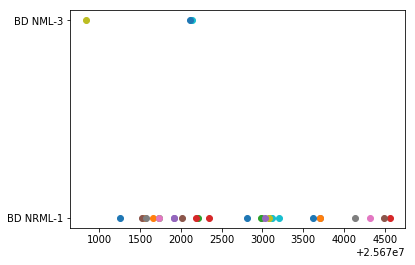

In [72]:
# visualize the optimal assignment
for i in ArrivalULDNumber_list:
    BreakDownZoneName_list1 = list(df_merge1[df_merge1.ArrivalULDNumber==i]['BreakDownZoneName'])
    for j in BreakDownZoneName_list1:
        #print(int(i),str(j))
        new_check = df_merge1[(df_merge1.ArrivalULDNumber==i) & (df_merge1.BreakDownZoneName==j)]
        shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
        shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
        for k in range(shipment_arrival_duation_minutes_loop):
            if x[i,j,(shipment_arrival_time_minutes_loop+k)].x > 0.5:
                #print(k)
                #print("DZ", i, "assigned to BD", j, "at", (shipment_arrival_time_minutes_loop+k))
                plt.plot(shipment_arrival_time_minutes_loop+k, j, "o")
# for j in range(m):    
#     plt.plot(1, j, "o")
# for i in range(n):
#     for j in range(m):
#         if x[i,j].x > 0.5:
#             plt.plot([0,1], [i,j], "k")# todo
plt.show

In [65]:
df_merge1[df_merge1.ArrivalULDNumber==80226]

,DropZone,ArrivalULDNumber,BreakDownZoneName,DropZoneName,TransportDuration,h,m,s,key,dz_type,bd_type1,bd_type,key_for_type,Shipment_duration_minutes,Shipment_arrival_time_minutes,Shipment_departure_time_minutes,Name,NumberOfWorkstations,handling_m,one_hour_duration
170,DZ NML-1,80226,BD NML-1,DZ NML-1,00:28:00,0,28,0,80226_BD NML-1,NML,NML-1,NML,1,3060,25672095,25675155,BD NML-1,4,13,60
173,DZ NML-1,80226,BD NML-2,DZ NML-1,00:26:00,0,26,0,80226_BD NML-2,NML,NML-2,NML,1,3060,25672095,25675155,BD NML-2,3,13,60
176,DZ NML-1,80226,BD NML-3,DZ NML-1,00:11:00,0,11,0,80226_BD NML-3,NML,NML-3,NML,1,3060,25672095,25675155,BD NML-3,5,20,60


In [66]:
booking[booking.ArrivalULDNumber==80226]

,Shipment ID,FlightDate,ShipmentArrivalDateUTC,ProductName,ShipmentOrigin,ShipmentDestination,CarrierCode,Priority,DropZone,FlightNumberArrival,...,TotalWeight,TotalNumberOfPieces,FlightNumberDeparture,ShipmentDepartureDateUTC,count_shipments,Shipment_arrival_date_time,Shipment_departure_date_time,Shipment_duration,build_up_arrival_time,build_up_finish_time
708,020-45528685,2018-10-23,2018-10-23T20:15:00,NML,BKK,QQQ,ZZ,False,DZ NML-1,8170,...,36.4,1,73,2018-10-25T23:15:00,1,2018-10-23 20:15:00,2018-10-25 23:15:00,2 days 03:00:00,2018-10-23 20:15:00,2018-10-25 23:15:00


In [ ]:
# for i in ArrivalULDNumber_list:
#     #for j in BreakDownZoneName_list:
#         #print(int(i),str(j))
#     new_check = df_merge1[(df_merge1.ArrivalULDNumber==i) & (df_merge1.BreakDownZoneName==j)]
#     shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
#     shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
#     arrival_time_each_uld = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
#     transport_time_each_bd_zone = list(new_check['m'].unique())[0]
#         #for k in range(shipment_arrival_duation_minutes_loop):
#     model.addConstr(quicksum((c-transport_time_each_bd_zone)*x[i,b,c] for b in BreakDownZoneName_list for c in range(shipment_arrival_time_minutes_loop, shipment_arrival_time_minutes_loop+shipment_arrival_duation_minutes_loop)) >= arrival_time_each_uld)

In [ ]:
# for i in ArrivalULDNumber_list:
#     #for j in BreakDownZoneName_list:
#         #print(int(i),str(j))
#     new_check = df_merge1[(df_merge1.ArrivalULDNumber==i) & (df_merge1.BreakDownZoneName==j)]
#     shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
#     shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
#     arrival_time_each_uld = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
#     transport_time_each_bd_zone = list(new_check['m'].unique())[0]
#         #for k in range(shipment_arrival_duation_minutes_loop):
#     model.addConstr(quicksum((c-df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['m'])*x[i,b,c] for b in BreakDownZoneName_list for c in range(shipment_arrival_time_minutes_loop, shipment_arrival_time_minutes_loop+shipment_arrival_duation_minutes_loop)) >= arrival_time_each_uld)

In [ ]:
# for i in ArrivalULDNumber_list:
#     for j in BreakDownZoneName_list:
#         #print(int(i),str(j))
#         new_check = df_merge1[(df_merge1.ArrivalULDNumber==i) & (df_merge1.BreakDownZoneName==j)]
#         shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
#         shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
#         handling_minutes = list(new_check['handling_m'].unique())[0]
#         cap = list(new_check['NumberOfWorkstations'].unique())[0]
#         #for k in range(shipment_arrival_time_minutes_loop+1, shipment_arrival_time_minutes_loop+shipment_arrival_duation_minutes_loop+1):
#         model.addConstr(cap - quicksum(x[a,j,range(shipment_arrival_time_minutes_loop, shipment_arrival_time_minutes_loop+shipment_arrival_duation_minutes_loop)] for a in ArrivalULDNumber_list) >= quicksum(x[p,j,r] for p in ArrivalULDNumber_list for r in range(shipment_arrival_time_minutes_loop, shipment_arrival_time_minutes_loop+handling_minutes)))

In [ ]:
# for j in BreakDownZoneName_list:
#         #print(int(i),str(j))
#     new_check = df_merge1[(df_merge1.BreakDownZoneName==j)]
#     min_time = min(list(new_check['Shipment_arrival_time_minutes'].unique()))
#     max_time = 60#max(list(new_check['Shipment_departure_time_minutes'].unique()))
#     #shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
#     #shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
#     handling_minutes = list(new_check['handling_m'].unique())[0]
#     #print(handling_minutes)
#     cap = list(new_check['NumberOfWorkstations'].unique())[0]
#     for t in range(min_time, max_time-handling_minutes):
#         #print(max_time)
#         model.addConstr(cap - quicksum(x[a,j,t] for a in ArrivalULDNumber_list) >= quicksum(x[p,j,r] for p in ArrivalULDNumber_list for r in range(t+1, t+handling_minutes)))
#     #for k in range(shipment_arrival_time_minutes_loop+1, shipment_arrival_time_minutes_loop+shipment_arrival_duation_minutes_loop+1):
    

In [ ]:
df_merge1.head()

In [ ]:
# t_max = model.addVar(vtype=GRB.INTEGER, obj=1.0, name="t_max")

In [ ]:
# for i in ArrivalULDNumber_list:
#         #print(int(i),str(j))
#     new_check = df_merge1[(df_merge1.ArrivalULDNumber==i)]
#     shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
#     shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
#     arrival_time_each_uld = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
#     transport_time_each_bd_zone = list(new_check['m'].unique())
#     model.addConstr(quicksum(c*x[i,b,c] for b in BreakDownZoneName_list for c in range(shipment_arrival_time_minutes_loop, shipment_arrival_time_minutes_loop+shipment_arrival_duation_minutes_loop)) <= t_max)

In [ ]:
model.optimize()

In [ ]:
for i in ArrivalULDNumber_list:
    for j in BreakDownZoneName_list:
        #print(int(i),str(j))
        new_check = df_merge1[(df_merge1.ArrivalULDNumber==i) & (df_merge1.BreakDownZoneName==j)]
        shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
        shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
        for k in range(shipment_arrival_duation_minutes_loop):
            t = model.addVar(obj=(shipment_arrival_time_minutes_loop+k+1), vtype=GRB.BASIC)

In [ ]:
df_merge1

In [ ]:
for i in ArrivalULDNumber_list:
    for j in BreakDownZoneName_list:
        #print(int(i),str(j))
        new_check = df_merge1[(df_merge1.ArrivalULDNumber==i) & (df_merge1.BreakDownZoneName==j)]
        shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
        shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
        model.addConstr(quicksum(x[i,b,c] for b in BreakDownZoneName_list for c in range(shipment_arrival_time_minutes_loop+1, shipment_arrival_time_minutes_loop+shipment_arrival_duation_minutes_loop+1)) == 1)

In [ ]:
max(t_max)

In [ ]:
#obj = t_max
#model.setObjective(obj, GRB.MINIMIZE)

In [ ]:
model.optimize()

In [ ]:
#x[21231, 'B BD NRML-1', 25671251].x
#df_merge1[df_merge1.ArrivalULDNumber == 76631]

In [ ]:
obj = x.sum()
model.setObjective(obj, GRB.MINIMIZE)

In [ ]:
model.optimize()

In [ ]:
for i in ArrivalULDNumber_list:
    for j in BreakDownZoneName_list:
        #print(int(i),str(j))
        new_check = df_merge1[(df_merge1.ArrivalULDNumber==i) & (df_merge1.BreakDownZoneName==j)]
        shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
        shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
        for k in range(shipment_arrival_duation_minutes_loop):
            if(x[i,j,(shipment_arrival_time_minutes_loop+k+1)].x>0.5):
                print(i, "assigned to", j, k)# todo

In [ ]:
model.write("bd_model.lp")

In [ ]:
import os
cwd = os.getcwd()

In [ ]:
cwd

In [ ]:
for i in ArrivalULDNumber_list:
    for j in BreakDownZoneName_list:
        #print(int(i),str(j))
        new_check = df_merge1[(df_merge1.ArrivalULDNumber==i) & (df_merge1.BreakDownZoneName==j)]
        shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
        shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
        for k in range(shipment_arrival_duation_minutes_loop):
            if x[i,j,(shipment_arrival_time_minutes_loop+k)].x > 0.5:
                print(k)
                print("DZ", i, "assigned to BD", j, "at", (shipment_arrival_time_minutes_loop+k))
# for i in drop_zones:
#     for j in break_down_zones:
#         if x[i,j].x > 0.5:
#             print("DZ", i, "assigned to BD", j)# todo

In [ ]:
df_merge1[df_merge1.BreakDownZoneName=='BD NRML-1'].iloc[0]['m']

In [75]:
list(range(1, 7, 2))

[1, 3, 5]

In [46]:
##########################################################################
##########################################################################
##########################################################################

In [73]:
pd.set_option('display.max_rows', 500)

In [47]:
bu_zones_workstations['count_workstation'] = 1
bu_zones_workstations.head()

,WorkStationID,Name,count_workstation
0,FT-1-1,BU FT-1,1
1,FT-1-2,BU FT-1,1
2,FT-1-3,BU FT-1,1
3,FT-1-4,BU FT-1,1
4,FT-1-5,BU FT-1,1


In [48]:
bu_zones_wokstations_count = pd.pivot_table(bu_zones_workstations, values='count_workstation', index=['Name'], aggfunc=np.sum, fill_value=0).reset_index()

In [62]:
bu_zones_to_flight_all = pd.merge(bu_zones_to_flight, bu_zones_wokstations_count, left_on='BU Zone', right_on='Name')

In [63]:
bu_zones_to_flight_all = pd.merge(bu_zones_to_flight_all, bu_zones, left_on='Name', right_on='Name')

(82, 3)

In [65]:
bu_zones_to_flight_all.shape

(82, 7)

In [64]:
bu_zones_to_flight_all.head()

,FlightNumber,BU Zone,TransportationDistance,Name,count_workstation,HandlingTimePerULD,TransportationTimeToWH
0,1,BU FT-1,00:05:00,BU FT-1,5,00:24:00,00:50:00
1,2,BU FT-1,00:11:00,BU FT-1,5,00:24:00,00:50:00
2,3,BU FT-1,00:19:00,BU FT-1,5,00:24:00,00:50:00
3,4,BU FT-1,00:24:00,BU FT-1,5,00:24:00,00:50:00
4,5,BU FT-1,00:05:00,BU FT-1,5,00:24:00,00:50:00


In [70]:
booking_new_BU = pd.merge(booking_new, bu_zones_to_flight_all, left_on='FlightNumber_x', right_on='FlightNumber')

In [72]:
booking_new_BU[['handling_ULD_h','handling_ULD_m','handling_ULD_s']] = pd.DataFrame([(x.hour, x.minute, x.second) for x in booking_new_BU['HandlingTimePerULD']])
booking_new_BU[['transport_WH_h','transport_WH_m','transport_WH_s']] = pd.DataFrame([(x.hour, x.minute, x.second) for x in booking_new_BU['TransportationTimeToWH']])

In [77]:
booking_new_BU.head()

,ProductName,Priority,DropZone,ArrivalULDNumber,Pieces,Weight,TotalWeight,FlightNumberDeparture,Shipment_arrival_date_time,Shipment_departure_date_time,...,count_workstation,HandlingTimePerULD,TransportationTimeToWH,handling_ULD_h,handling_ULD_m,handling_ULD_s,transport_WH_h,transport_WH_m,transport_WH_s,shipment_ID
0,NRML,False,DZ NRML-2,24321,1,15.3,15.3,77,2018-10-23 06:10:00,2018-10-24 20:25:00,...,7,00:17:00,00:50:00,0,17,0,0,50,0,1
1,NRML,False,DZ NRML-2,34576,7,9.5,9.5,77,2018-10-23 14:10:00,2018-10-24 20:25:00,...,7,00:17:00,00:50:00,0,17,0,0,50,0,2
2,NRML,False,DZ NRML-2,34576,6,6.2,6.2,77,2018-10-23 14:10:00,2018-10-24 20:25:00,...,7,00:17:00,00:50:00,0,17,0,0,50,0,3
3,NRML,False,DZ NRML-1,53456,1,2.5,2.5,77,2018-10-23 17:10:00,2018-10-24 20:25:00,...,7,00:17:00,00:50:00,0,17,0,0,50,0,4
4,NRML,False,DZ NRML-1,80167,1,15.3,15.3,77,2018-10-24 10:55:00,2018-10-24 20:25:00,...,7,00:17:00,00:50:00,0,17,0,0,50,0,5


In [87]:
booking_new_BU.columns

Index(['ProductName', 'Priority', 'DropZone', 'ArrivalULDNumber', 'Pieces',
       'Weight', 'TotalWeight', 'FlightNumberDeparture',
       'Shipment_arrival_date_time', 'Shipment_departure_date_time',
       'Shipment_duration', 'build_up_arrival_time', 'build_up_finish_time',
       'FlightNumber_x', 'BU Zone_x', 'TransportationDistance_x', 'Name_x',
       'HandlingTimePerULD_x', 'TransportationTimeToWH_x', 'Name_y',
       'HandlingTimePerULD_y', 'TransportationTimeToWH_y', 'Count',
       'FlightNumber_y', 'BU Zone_y', 'TransportationDistance_y',
       'ULD_handling_h', 'ULD_handling_m', 'ULD_handling_s', 'arrival_date',
       'departure_date', 'Shipment_duration_minutes',
       'Shipment_arrival_time_minutes', 'Shipment_departure_time_minutes',
       'FlightNumber', 'BU Zone', 'TransportationDistance', 'Name',
       'count_workstation', 'HandlingTimePerULD', 'TransportationTimeToWH',
       'handling_ULD_h', 'handling_ULD_m', 'handling_ULD_s', 'transport_WH_h',
       'trans

In [147]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 500)
booking_new_BU[booking_new_BU.FlightNumber_y==1]

,ProductName,Priority,DropZone,ArrivalULDNumber,Pieces,Weight,TotalWeight,FlightNumberDeparture,Shipment_arrival_date_time,Shipment_departure_date_time,Shipment_duration,build_up_arrival_time,build_up_finish_time,FlightNumber_x,BU Zone_x,TransportationDistance_x,Name_x,HandlingTimePerULD_x,TransportationTimeToWH_x,Name_y,HandlingTimePerULD_y,TransportationTimeToWH_y,Count,FlightNumber_y,BU Zone_y,TransportationDistance_y,ULD_handling_h,ULD_handling_m,ULD_handling_s,arrival_date,departure_date,Shipment_duration_minutes,Shipment_arrival_time_minutes,Shipment_departure_time_minutes,FlightNumber,BU Zone,TransportationDistance,Name,count_workstation,HandlingTimePerULD,TransportationTimeToWH,handling_ULD_h,handling_ULD_m,handling_ULD_s,transport_WH_h,transport_WH_m,transport_WH_s,shipment_ID
53,NRML,False,DZ NRML-2,24321,1,85.5,85.5,1,2018-10-23 06:10:00,2018-10-24 05:00:00,0 days 22:50:00,2018-10-23 06:10:00,2018-10-24 05:00:00,1,BU FT-1,00:05:00,BU FT-1,00:24:00,00:50:00,BU FT-1,00:24:00,00:50:00,5,1,BU FT-1,00:05:00,0,24,0,2018-10-23,2018-10-24,1370,25671250,25672620,1,BU FT-1,00:05:00,BU FT-1,5,00:24:00,00:50:00,0,24,0,0,50,0,54
54,NRML,False,DZ NRML-2,24321,2,0.8,0.8,1,2018-10-23 06:10:00,2018-10-24 05:00:00,0 days 22:50:00,2018-10-23 06:10:00,2018-10-24 05:00:00,1,BU FT-1,00:05:00,BU FT-1,00:24:00,00:50:00,BU FT-1,00:24:00,00:50:00,5,1,BU FT-1,00:05:00,0,24,0,2018-10-23,2018-10-24,1370,25671250,25672620,1,BU FT-1,00:05:00,BU FT-1,5,00:24:00,00:50:00,0,24,0,0,50,0,55
55,NRML,False,DZ NRML-2,24321,1,3.8,3.8,1,2018-10-23 06:10:00,2018-10-24 05:00:00,0 days 22:50:00,2018-10-23 06:10:00,2018-10-24 05:00:00,1,BU FT-1,00:05:00,BU FT-1,00:24:00,00:50:00,BU FT-1,00:24:00,00:50:00,5,1,BU FT-1,00:05:00,0,24,0,2018-10-23,2018-10-24,1370,25671250,25672620,1,BU FT-1,00:05:00,BU FT-1,5,00:24:00,00:50:00,0,24,0,0,50,0,56
56,NRML,False,DZ NRML-2,24321,1,32.8,32.8,1,2018-10-23 06:10:00,2018-10-24 05:00:00,0 days 22:50:00,2018-10-23 06:10:00,2018-10-24 05:00:00,1,BU FT-1,00:05:00,BU FT-1,00:24:00,00:50:00,BU FT-1,00:24:00,00:50:00,5,1,BU FT-1,00:05:00,0,24,0,2018-10-23,2018-10-24,1370,25671250,25672620,1,BU FT-1,00:05:00,BU FT-1,5,00:24:00,00:50:00,0,24,0,0,50,0,57
57,NRML,False,DZ NRML-2,24321,1,20.5,20.5,1,2018-10-23 06:10:00,2018-10-24 05:00:00,0 days 22:50:00,2018-10-23 06:10:00,2018-10-24 05:00:00,1,BU FT-1,00:05:00,BU FT-1,00:24:00,00:50:00,BU FT-1,00:24:00,00:50:00,5,1,BU FT-1,00:05:00,0,24,0,2018-10-23,2018-10-24,1370,25671250,25672620,1,BU FT-1,00:05:00,BU FT-1,5,00:24:00,00:50:00,0,24,0,0,50,0,58
58,NRML,True,DZ NRML-2,24321,3,3.4,3.4,1,2018-10-23 06:10:00,2018-10-24 05:00:00,0 days 22:50:00,2018-10-23 06:10:00,2018-10-24 05:00:00,1,BU FT-1,00:05:00,BU FT-1,00:24:00,00:50:00,BU FT-1,00:24:00,00:50:00,5,1,BU FT-1,00:05:00,0,24,0,2018-10-23,2018-10-24,1370,25671250,25672620,1,BU FT-1,00:05:00,BU FT-1,5,00:24:00,00:50:00,0,24,0,0,50,0,59
59,NRML,True,DZ NRML-2,24321,1,0.4,0.4,1,2018-10-23 06:10:00,2018-10-24 05:00:00,0 days 22:50:00,2018-10-23 06:10:00,2018-10-24 05:00:00,1,BU FT-1,00:05:00,BU FT-1,00:24:00,00:50:00,BU FT-1,00:24:00,00:50:00,5,1,BU FT-1,00:05:00,0,24,0,2018-10-23,2018-10-24,1370,25671250,25672620,1,BU FT-1,00:05:00,BU FT-1,5,00:24:00,00:50:00,0,24,0,0,50,0,60
60,NRML,False,DZ NRML-2,24321,1,1.5,1.5,1,2018-10-23 06:10:00,2018-10-24 05:00:00,0 days 22:50:00,2018-10-23 06:10:00,2018-10-24 05:00:00,1,BU FT-1,00:05:00,BU FT-1,00:24:00,00:50:00,BU FT-1,00:24:00,00:50:00,5,1,BU FT-1,00:05:00,0,24,0,2018-10-23,2018-10-24,1370,25671250,25672620,1,BU FT-1,00:05:00,BU FT-1,5,00:24:00,00:50:00,0,24,0,0,50,0,61
61,NRML,False,DZ NRML-2,24321,2,1.5,1.5,1,2018-10-23 06:10:00,2018-10-24 05:00:00,0 days 22:50:00,2018-10-23 06:10:00,2018-10-24 05:00:00,1,BU FT-1,00:05:00,BU FT-1,00:24:00,00:50:00,BU FT-1,00:24:00,00:50:00,5,1,BU FT-1,00:05:00,0,24,0,2018-10-23,2018-10-24,1370,25671250,25672620,1,BU FT-1,00:05:00,BU FT-1,5,00:24:00,00:50:00,0,24,0,0,50,0,62
62,NRML,False,DZ NRML-2,24321,1,140.8,140.8,1,2018-10-23 06:10:00,2018-10-24 05:00:00

In [76]:
booking_new_BU['shipment_ID'] = range(1, len(booking_new_BU) + 1)

In [78]:
shipment_id_list = list(booking_new_BU['shipment_ID'].unique())

In [134]:
#Check Arrival ULD 
sample_shipments_bu = booking_new_BU.iloc[0:100,:]
ArrivalULDNumber_list = list(sample_shipments_bu['ArrivalULDNumber'].unique())

In [135]:
filghts_list = list(sample_shipments_bu['FlightNumberDeparture'].unique())
filghts_list

[77, 78, 79, 82, 81, 75, 71, 74, 73, 72, 76, 80, 1]

In [136]:
model = Model('BU zone model')

In [137]:
#Variable creation




In [138]:
#Discretisation has been done based on each BD zone handling times
z = {}
for i in ArrivalULDNumber_list:
    shipment_list = list(sample_shipments_bu[sample_shipments_bu.ArrivalULDNumber==i]['shipment_ID'])
    #print(shipment_list)
    for l in shipment_list:
        #print(int(i),str(j))
        number_of_ws = sample_shipments_bu[(sample_shipments_bu.ArrivalULDNumber==i) & (sample_shipments_bu.shipment_ID==l)]['count_workstation'].unique()[0]
        shipment_departure_time_minutes_loop = sample_shipments_bu[(sample_shipments_bu.ArrivalULDNumber==i) & (sample_shipments_bu.shipment_ID==l)]['Shipment_departure_time_minutes'].unique()[0]
        for m in range(1,number_of_ws+1):
            for t in range(shipment_departure_time_minutes_loop-60, shipment_departure_time_minutes_loop):
                z[l,m,t] = model.addVar(vtype=GRB.BINARY)
#         min_time = min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique()))
#         shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
#         shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
#         handling_minutes = list(new_check['handling_m'].unique())[0]
#         t_start = shipment_arrival_time_minutes_loop + (handling_minutes - (shipment_arrival_time_minutes_loop%min_time))
#         for k in range(t_start, t_start+shipment_arrival_duation_minutes_loop, handling_minutes):
#             x[i,j,k] = model.addVar(vtype=GRB.BINARY)

In [142]:
print(z)

{(1, 1, 25673485): <gurobi.Var *Awaiting Model Update*>, (1, 1, 25673486): <gurobi.Var *Awaiting Model Update*>, (1, 1, 25673487): <gurobi.Var *Awaiting Model Update*>, (1, 1, 25673488): <gurobi.Var *Awaiting Model Update*>, (1, 1, 25673489): <gurobi.Var *Awaiting Model Update*>, (1, 1, 25673490): <gurobi.Var *Awaiting Model Update*>, (1, 1, 25673491): <gurobi.Var *Awaiting Model Update*>, (1, 1, 25673492): <gurobi.Var *Awaiting Model Update*>, (1, 1, 25673493): <gurobi.Var *Awaiting Model Update*>, (1, 1, 25673494): <gurobi.Var *Awaiting Model Update*>, (1, 1, 25673495): <gurobi.Var *Awaiting Model Update*>, (1, 1, 25673496): <gurobi.Var *Awaiting Model Update*>, (1, 1, 25673497): <gurobi.Var *Awaiting Model Update*>, (1, 1, 25673498): <gurobi.Var *Awaiting Model Update*>, (1, 1, 25673499): <gurobi.Var *Awaiting Model Update*>, (1, 1, 25673500): <gurobi.Var *Awaiting Model Update*>, (1, 1, 25673501): <gurobi.Var *Awaiting Model Update*>, (1, 1, 25673502): <gurobi.Var *Awaiting Model U

In [139]:
q = {}
for k in filghts_list:
    ws_list = sample_shipments_bu[sample_shipments_bu.FlightNumberDeparture==k]['count_workstation'].unique()[0]
    shipment_departure_time_minutes_loop = sample_shipments_bu[(sample_shipments_bu.FlightNumberDeparture==k)]['Shipment_departure_time_minutes'].unique()[0]
    #print(shipment_list)
    for m in range(1, ws_list+1):
        #print(int(i),str(j))
        for t in range(shipment_departure_time_minutes_loop-60, shipment_departure_time_minutes_loop):
                q[k,m,t] = model.addVar(vtype=GRB.BINARY)

In [140]:
for k in filghts_list:
    shipment_list = list(sample_shipments_bu[sample_shipments_bu.FlightNumberDeparture==k]['shipment_ID'])
    ws_list = sample_shipments_bu[sample_shipments_bu.FlightNumberDeparture==k]['count_workstation'].unique()[0]
    shipment_departure_time_minutes_loop = sample_shipments_bu[(sample_shipments_bu.FlightNumberDeparture==k)]['Shipment_departure_time_minutes'].unique()[0]
    #print(shipment_list)
    for l in shipment_list:
        #print(int(i),str(j))
        model.addConstr(quicksum(z[l,m,t] for m in range(1, ws_list+1) for t in range(shipment_departure_time_minutes_loop-60, shipment_departure_time_minutes_loop))==1)

KeyError: (64, 1, 25672560)

In [99]:
for k in filghts_list:
    shipment_list = list(sample_shipments_bu[sample_shipments_bu.FlightNumberDeparture==k]['shipment_ID'])
    ws_list = sample_shipments_bu[sample_shipments_bu.FlightNumberDeparture==k]['count_workstation'].unique()[0]
    shipment_departure_time_minutes_loop = sample_shipments_bu[(sample_shipments_bu.FlightNumberDeparture==k)]['Shipment_departure_time_minutes'].unique()[0]
    bu_handling_time = sample_shipments_bu[sample_shipments_bu.FlightNumberDeparture==k]['handling_ULD_m'].unique()[0]
    #print(shipment_list)
    for m in range(1, ws_list+1):
        for t in range(shipment_departure_time_minutes_loop-60, shipment_departure_time_minutes_loop-bu_handling_time):
            model.addConstr(400*q[k,m,t] - quicksum(sample_shipments_bu[sample_shipments_bu.shipment_ID==l].iloc[0]['TotalWeight']*z[l,m,t] for l in shipment_list)
                            >= quicksum(sample_shipments_bu[sample_shipments_bu.shipment_ID==l].iloc[0]['TotalWeight']*z[l,m,tau] for l in shipment_list for tau in range(t+1,t+bu_handling_time)))
        
       
                            
    

In [109]:
for k in filghts_list:
    shipment_list = list(sample_shipments_bu[sample_shipments_bu.FlightNumberDeparture==k]['shipment_ID'])
    ws_list = sample_shipments_bu[sample_shipments_bu.FlightNumberDeparture==k]['count_workstation'].unique()[0]
    shipment_departure_time_minutes_loop = sample_shipments_bu[(sample_shipments_bu.FlightNumberDeparture==k)]['Shipment_departure_time_minutes'].unique()[0]
    bu_handling_time = sample_shipments_bu[sample_shipments_bu.FlightNumberDeparture==k]['handling_ULD_m'].unique()[0]
    model.addConstr(quicksum(q[k,m,t] for m in range(1, ws_list+1) for t in range(shipment_departure_time_minutes_loop-60, shipment_departure_time_minutes_loop)) <= (quicksum(sample_shipments_bu[sample_shipments_bu.shipment_ID==l].iloc[0]['TotalWeight']*z[l,m,t] for l in shipment_list for t in range(shipment_departure_time_minutes_loop-60,shipment_departure_time_minutes_loop) for m in range(1, ws_list+1))/400) + 1)

In [128]:
for k in filghts_list:
    bu_zone_for_flight = sample_shipments_bu[sample_shipments_bu.FlightNumberDeparture==k]['Name'].unique()[0]
    othe_flights_df = sample_shipments_bu[sample_shipments_bu.Name==bu_zone_for_flight]
    ws_list = sample_shipments_bu[sample_shipments_bu.FlightNumberDeparture==k]['count_workstation'].unique()[0]
    shipment_departure_time_minutes_loop = sample_shipments_bu[(sample_shipments_bu.FlightNumberDeparture==k)]['Shipment_departure_time_minutes'].unique()[0]
    other_flights = list(othe_flights_df[othe_flights_df['FlightNumberDeparture'].isin([k]) == False]['FlightNumberDeparture'].unique())
    bu_handling_time = sample_shipments_bu[sample_shipments_bu.FlightNumberDeparture==k]['handling_ULD_m'].unique()[0]
    #print(k, "----",filghts_list,"-------", other_flights) 
    #print(shipment_list)
    for m in range(1, ws_list+1):
        #print(int(i),str(j))
        for t in range(shipment_departure_time_minutes_loop-60, shipment_departure_time_minutes_loop - bu_handling_time):
            other_list  =[]
            for i in other_flights:
                if(t in range((sample_shipments_bu[sample_shipments_bu.FlightNumberDeparture==i].iloc[0]['Shipment_departure_time_minutes']-60),sample_shipments_bu[sample_shipments_bu.FlightNumberDeparture==i].iloc[0]['Shipment_departure_time_minutes'])): 
                    other_list.append(i)
            model.addConstr(1-q[k,m,t] >= quicksum(q[p,m,ta] for p in other_list for ta in range(t,t+bu_handling_time)))

In [118]:
obj = 0
for i in ArrivalULDNumber_list:
        #print(int(i),str(j))
    BreakDownZoneName_list1 = list(df_merge1[df_merge1.ArrivalULDNumber==i]['BreakDownZoneName'])
    new_check = df_merge1[(df_merge1.ArrivalULDNumber==i)]
    shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
    shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
    arrival_time_each_uld = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
    transport_time_each_bd_zone = list(new_check['m'].unique())
    obj += quicksum(c*z[l,m,t] for b in BreakDownZoneName_list1 for c in range((shipment_arrival_time_minutes_loop + (df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m'] - (shipment_arrival_time_minutes_loop%min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique()))))), (shipment_arrival_time_minutes_loop + (df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m'] - (shipment_arrival_time_minutes_loop%min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))))+shipment_arrival_duation_minutes_loop, df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))
#obj = x.sum()

[]

In [129]:
obj = 0
for i in ArrivalULDNumber_list:
    shipment_list = list(sample_shipments_bu[sample_shipments_bu.ArrivalULDNumber==i]['shipment_ID'])
    #print(shipment_list)
    for l in shipment_list:
        #print(int(i),str(j))
        number_of_ws = sample_shipments_bu[(sample_shipments_bu.ArrivalULDNumber==i) & (sample_shipments_bu.shipment_ID==l)]['count_workstation'].unique()[0]
        shipment_departure_time_minutes_loop = sample_shipments_bu[(sample_shipments_bu.ArrivalULDNumber==i) & (sample_shipments_bu.shipment_ID==l)]['Shipment_departure_time_minutes'].unique()[0]
        obj += quicksum(t*z[l,m,t] for m in range(1,number_of_ws+1) for t in range(shipment_departure_time_minutes_loop-60, shipment_departure_time_minutes_loop))

In [130]:
model.setObjective(obj, GRB.MINIMIZE)

In [131]:
model.optimize()

Optimize a model with 1262 rows, 5040 columns and 72682 nonzeros
Variable types: 0 continuous, 5040 integer (5040 binary)
Coefficient statistics:
  Matrix range     [6e-03, 1e+03]
  Objective range  [3e+07, 3e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 2.567389e+08
Presolve removed 1253 rows and 5017 columns
Presolve time: 0.26s
Presolved: 9 rows, 23 columns, 52 nonzeros
Variable types: 0 continuous, 23 integer (23 binary)

Root relaxation: objective 2.567389e+08, 1 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    2.567389e+08 2.5674e+08  0.00%     -    0s

Explored 0 nodes (1 simplex iterations) in 0.42 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 2.56739e+08 2.56739e+08 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.56

In [133]:
for i in ArrivalULDNumber_list:
    shipment_list = list(sample_shipments_bu[sample_shipments_bu.ArrivalULDNumber==i]['shipment_ID'])
    #print(shipment_list)
    for l in shipment_list:
        #print(int(i),str(j))
        number_of_ws = sample_shipments_bu[(sample_shipments_bu.ArrivalULDNumber==i) & (sample_shipments_bu.shipment_ID==l)]['count_workstation'].unique()[0]
        shipment_departure_time_minutes_loop = sample_shipments_bu[(sample_shipments_bu.ArrivalULDNumber==i) & (sample_shipments_bu.shipment_ID==l)]['Shipment_departure_time_minutes'].unique()[0]
        for m in range(1,number_of_ws+1):
            for t in range(shipment_departure_time_minutes_loop-60, shipment_departure_time_minutes_loop):
                if z[l,m,t].x > 0.5:
                    print("Shipment", l, "assigned to WS", m, "at", t)

Shipment 1 assigned to WS 3 at 25673544
Shipment 9 assigned to WS 5 at 25675230
Shipment 2 assigned to WS 3 at 25673544
Shipment 3 assigned to WS 3 at 25673544
Shipment 4 assigned to WS 4 at 25673544
Shipment 5 assigned to WS 6 at 25673544
Shipment 6 assigned to WS 7 at 25673544
Shipment 7 assigned to WS 7 at 25673544
Shipment 8 assigned to WS 5 at 25673544
Shipment 10 assigned to WS 2 at 25675289


In [ ]:
for i in ArrivalULDNumber_list:
    shipment_list = list(sample_shipments_bu[sample_shipments_bu.ArrivalULDNumber==i]['shipment_ID'])
    #print(shipment_list)
    for l in shipment_list:
        #print(int(i),str(j))
        number_of_ws = sample_shipments_bu[(sample_shipments_bu.ArrivalULDNumber==i) & (sample_shipments_bu.shipment_ID==l)]['count_workstation'].unique()[0]
        shipment_departure_time_minutes_loop = sample_shipments_bu[(sample_shipments_bu.ArrivalULDNumber==i) & (sample_shipments_bu.shipment_ID==l)]['Shipment_departure_time_minutes'].unique()[0]
        for m in range(1,number_of_ws+1):
            for t in range(shipment_departure_time_minutes_loop-60, shipment_departure_time_minutes_loop):
                

In [100]:
model.write("test_BU_1.lp")